In [50]:

#Quantum machine import 
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.octave import *
from qm.qua import *
from configuration import *

#General os library 
import os
import time
import sys


from qualang_tools.units import unit
from set_octave import get_L0_and_IF
from qm import SimulationConfig, LoopbackInterface
from qualang_tools.units import unit
from qualang_tools.loops import from_array
from qualang_tools.plot import interrupt_on_close
from qualang_tools.results import progress_counter, fetching_tool
u = unit()


#Personal Library 
sys.path.append('C:\\Users\\hqclabo\\Documents\\Python Scripts\\Python Drivers')
from RohdeSchwartz import FSW
sys.path.append(r'C:\Users\hqclabo\Documents\Code\gbeaulieu') # path for my program AnFunc
import AnFunc as an 


from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from IPython.display import display
import scipy.io

## Spectrum Analyzer Setup

https://www.itu.int/en/ITU-D/Regional-Presence/ArabStates/Documents/events/2020/SM/Pres/S2D3Spectrum%20Analyzer.pdf

Reference level : is the top edge of the display and represents the maximum power expected at the spectrum analyzer input. Typically, we want ther reference level to be slighly above above our signal power. Setting the reference level too high or too low decrease the dynammic range. 

Input attenuator : When we set the reference level, the input attenuator is adjusted to have a proper gain and avoid overloading the isntrument

RBW: spectrum analyzer performs heterodyne measurement. The RBW sets the size of the IF filter before the detector. Can be understood as a filter sweeping on the signal. The RBW also affects the noise floor. Decreasing the RBW by a factor of 10 decreases the noise floor by a factor of 10 dBm. 

VBW : filter used to average or smooth out the displayed trace. Only affect how it is displayed and not acquired. The video bandwidth only reduces the noise on the trace. It doesn not lower the noise floor or imporve frequency resolution or signal separation. 

In [48]:
sa =  FSW('TCPIP0::169.254.209.74::inst0::INSTR')


### Tunable parameters - Works with a pulse length of 35 ms and delay of 500 000 ns and time sleep of 0.2 s
# centerSpan = True
# centerFreq =4.3310e9 #8.663e9
# spanFreq = 50e3#1e6    
# pointsNum = 1001
# RBW_bandwidth = 25
# VBW_bandwidth = 25
# level=0.5



#Works with a pulse length of 100 ms delay of 500 m_s and a delay of 500 000 ns and a time of sleep of 0.6 s 
centerSpan = True
centerFreq =4.333e9 #8.663e9
spanFreq = 10e3#1e6    
pointsNum = 1001
RBW_bandwidth = 10
VBW_bandwidth = 2
level=0.5

#- Works with a pulse length of 100 ms delay of 500 000 ns and a time of sleep of 0.4 s
centerSpan = True
centerFreq =4.3333e9 #8.663e9
spanFreq = 10e3#1e6    
pointsNum = 1001
RBW_bandwidth = 20
VBW_bandwidth = 1
level=0.5

#Works with a pulse of 800 ms and delay of 10 ms and time sleep of 
centerSpan = True
centerFreq =4.33335e9 #8.663e9
spanFreq = 10e3#1e6    
pointsNum = 1001
RBW_bandwidth = 10
VBW_bandwidth = 10
level=0.5



if centerSpan:
    startFreq = centerFreq - spanFreq/2
    stopFreq = centerFreq + spanFreq/2
    
    
sa.set_RBW(RBW_bandwidth) # set RBW bandwidth
sa.set_VBW(VBW_bandwidth) # set the VBW bandwidth 
sa.set_sweep(startFreq, stopFreq, pointsNum)  # set the sweep 
sa.set_trig(level) # sets the continuous trigger mode 
sa.set_input_coupling("AC")
sa.set_input_impedance(50)
sa.set_continuous("on")
sa.set_display(0)


## Octave & OPX configuration

In [51]:
#Octave & OPX configuration 
opx_ip = '128.178.175.167'
opx_port = 81
octave_ip = '128.178.175.167'
octave_port = 53


octave_config = QmOctaveConfig()
octave_config.set_calibration_db(os.getcwd()) #Path to the calibration database 

octave_config.add_device_info('octave1', octave_ip, octave_port) #Add a device refered to as octave 1
octave_config.set_opx_octave_mapping([('con1', 'octave1')])  # set default mapping between analog outputs of OPX and the octave

#Default Mapping reminder 
# portmap = {('con1', 1): ('octave1', 'I1'),
#            ('con1', 2): ('octave1', 'Q1'),
#            ('con1', 3): ('octave1', 'I2'),
#            ('con1', 4): ('octave1', 'Q2'),
#            ('con1', 5): ('octave1', 'I3'),
#            ('con1', 6): ('octave1', 'Q3'),
#            ('con1', 7): ('octave1', 'I4'),
#            ('con1', 8): ('octave1', 'Q4'),
#            ('con1', 9): ('octave1', 'I5'),
#            ('con1', 10): ('octave1', 'Q5')}

qmm = QuantumMachinesManager(host=opx_ip, port=opx_port, octave=octave_config)
qm = qmm.open_qm(config)


#Mixers for the fluxline 
qmm.octave_manager.set_clock("octave1", ClockType.External, ClockFrequency.MHZ_10) # External clock on the octave 
qm.octave.set_lo_source("fluxline", OctaveLOSource.Internal) # Use internal LO for the fluxline 
qm.octave.set_lo_frequency("fluxline", LO_fluxline)  # Set the frequency of the LO 
qm.octave.set_rf_output_gain("fluxline", -10)  # can set gain from -10dB to 20dB
qm.octave.set_rf_output_mode("fluxline", RFOutputMode.on)  # The LO output is always on (could change to a trigger)

KeyboardInterrupt: 

## Testing the pump

Sets of programs for calibrating the pump at the frequency defined in the configuration file and also playing an infinite pulse to look at the spectrum Analyzer

In [4]:
#Calibration of the fluxline mixer 
qm.octave.calibrate_element("fluxline", [get_L0_and_IF(config, "fluxline")])  
qm = qmm.open_qm(config)

2023-03-23 19:04:12,052 - qm - INFO - Flags: 
2023-03-23 19:04:12,052 - qm - INFO - Compiling program
2023-03-23 19:04:14,740 - qm - INFO - Sending pre-compiled program to QOP


In [8]:
# Applies a continious pump for testing 

with program() as TwoPhoton:
    with infinite_loop_():
        play("pumping"*amp(0.4), 'fluxline')
           
job = qm.execute(TwoPhoton)

2023-03-23 19:09:48,387 - qm - INFO - Flags: 
2023-03-23 19:09:48,388 - qm - INFO - Sending program to QOP
2023-03-23 19:09:48,412 - qm - INFO - Executing program


In [6]:
job.halt()

True

## Testing of the pump and trigger

Program for testing the trigger with the pump. The program plays the pump pulse as defined in the configuation file. The pulse triggers the Analyzer and the spectrum can then be collected

In [51]:
#On the analyzer, you need to press on the trigger button select the channel and then select run single or run continously to measure multiple



with program() as TriggerTest:
    
    #update_frequency("fluxline",0.1e9) #fluxline offset 
    play("pumping"*amp(0.6), 'fluxline')
    
    

simulation = False

if simulation:
    simulation_config = SimulationConfig(
        duration=10000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )
    
    job = qmm.simulate(config, TriggerTest, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'3','4' },digital_ports={'1','3'})

    
    
else:
    job = qm.execute(TriggerTest)
        

2023-03-23 19:22:28,547 - qm - INFO - Flags: 
2023-03-23 19:22:28,547 - qm - INFO - Sending program to QOP
2023-03-23 19:22:28,571 - qm - INFO - Executing program


In [52]:
#Collects the data 

[freq, val] = sa.collect_spectrum()

plt.plot(freq, val)
plt.show()

In [10]:
VBW_bandwidth

2

In [7]:
#Calibration of the mixer 

with program() as TwoPhoton:
    with infinite_loop_():
        play("pumping"*amp(0.5), 'fluxline')
        
print("-" * 36 + " Octave calibration")
# Step 5.1: Connect RF1 and run these lines in order to see the uncalibrated signal first
job = qm.execute(TwoPhoton)
time.sleep(1) # The program will run for 30 seconds
job.halt()
# Step 5.2: Run these in order to calibrate

   
qm.octave.calibrate_element('fluxline', [get_L0_and_IF(config, 'fluxline')])  # can provide many pairs of LO & IFs.
qm = qmm.open_qm(config)
#Step 5.3: Run these and look at the spectrum analyzer and check if you get 1 peak at LO+IF (i.e. 6.05GHz)
job = qm.execute(TwoPhoton)
time.sleep(1) #The program will run for 30 seconds8
job.halt()


------------------------------------ Octave calibration
2023-02-27 18:37:38,910 - qm - INFO - Flags: 
2023-02-27 18:37:38,910 - qm - INFO - Sending program to QOP
2023-02-27 18:37:55,509 - qm - INFO - Executing program
2023-02-27 18:37:57,800 - qm - INFO - Flags: 
2023-02-27 18:37:57,800 - qm - INFO - Compiling program
2023-02-27 18:38:01,792 - qm - INFO - Sending pre-compiled program to QOP
2023-02-27 18:38:04,817 - qm - INFO - Flags: 
2023-02-27 18:38:04,819 - qm - INFO - Sending program to QOP
2023-02-27 18:38:32,552 - qm - INFO - Executing program


True

## Testing for full program with updating frequencies 

Porgramm for a single frequency with the trigger. This program sweeps the frequency of the pump and looks at the network analyzer where it is defined. The settings of the network analyzer are as defined in the cell above

In [31]:
%%time


# Frequency sweep 
span=10 * u.kHz # Span of the pumping 
df = 1 * u.kHz # Step of the pumping 
freqs = np.arange(IF_fluxline-span/2, IF_fluxline+span/2, df) #sets of frequencies

Data=np.zeros((2,pointsNum))


#defines the program 
with program() as MultiTriggerTest:
    
    f = declare(int) # frequency 
    n = declare(int) #iteration index
    n_st = declare_stream()
    

    with for_(*from_array(f,freqs)):

        update_frequency("fluxline",f) # updates the IF frequency to the array 

        play("pumping"*amp(0.4), 'fluxline') #Plays the pump pulse on the flux line 

        pause() # pause to collect the data from the trigger 

           

job = qm.execute(MultiTriggerTest)  # Execute QUA program  

    



for j in range(len(freqs)):
    
  
    while not job.is_paused():
        time.sleep(0.001)
       
  
   
    #Data is collected here in a 3d matrix. Each page of the 3D matrix correspond to a 2 d matrix 
    # with two rows. One row being the frequency and the other being the signal 
    
    #time.sleep(pointsNum/RBW_bandwidth**2) #time delay for the acquisition 
    print(j/len(freqs))
    time.sleep(0.4)
    
    
    [Analyzer_freq, Analyzer_value] = sa.collect_spectrum() # Collect the spectrum 
    
    Analyzer_value=Analyzer_value.transpose()
    Analyzer_freq=Analyzer_freq.reshape(1,Analyzer_freq.shape[0])
    single_trace=np.vstack([Analyzer_value, Analyzer_freq])
    Data=np.dstack((Data,single_trace)) # Stacks all of the 2D matrix into a 3D matrix 

    job.resume()  # Resume to the program

    
 

2023-03-23 19:21:16,555 - qm - INFO - Flags: 
2023-03-23 19:21:16,555 - qm - INFO - Sending program to QOP
2023-03-23 19:21:16,750 - qm - INFO - Executing program
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
Wall time: 10.6 s


In [32]:
%matplotlib qt
#np.zeros((len(freqs),len(freqs),len(freqs)))

fig= plt.figure()
ax=fig.add_axes([0.1, 0.1 ,0.9, 0.9])

ax.set_xlabel("Analyzer Frequency", fontsize=14)
ax.set_ylabel("IF pulse frequency", fontsize=14)


ax.pcolormesh(Data[1,:,1],freqs,Data[0,:,1:].transpose(),cmap= "viridis",shading="auto")

#ax.plot(freqs+LO_fluxline,freqs,'r',marker=".",linestyle = 'None')  #points that we are looking at for the pump line only

ax.plot((freqs+LO_fluxline)/2,freqs,'r',marker=".",linestyle = 'None') #points that we are looking at for the half of the pump 



#idx=6
#plt.plot(Data[1,:,idx],Data[0,:,idx])

#Data.shape

# Problem is that the function collect the data directly on the analyzer and doesn't necessarily wait for the next measurement 

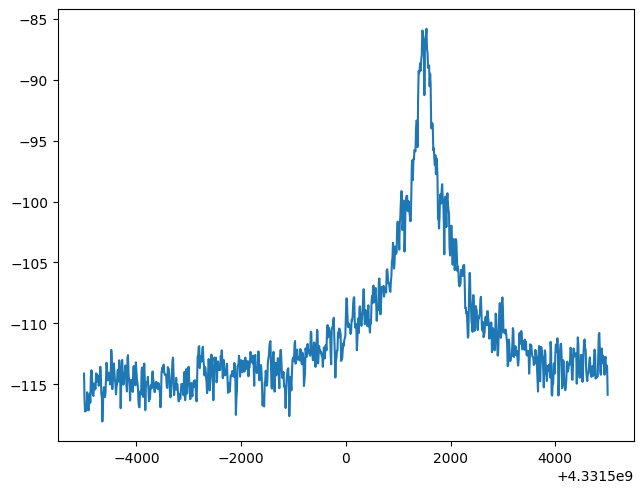

In [55]:
%matplotlib inline
fig=plt.figure()
idx=9
ax=fig.add_axes([0.1, 0.1 ,0.9, 0.9])
ax.plot(Data[1,:,idx],Data[0,:,idx])

## Program sweeping pump frequency and amplitude

The program here sweeps the frequency of the pump and for each frequency. For each pump frequency, the amplitude is then sweep. 

In [12]:
%%time
# Same program that sweeps the frequency of the pump source.But now also sweeps the amplitude. 
        
        
# Frequency sweep 
# span=1 * u.MHz # Span of the pumping 
# df = 0.05 * u.MHz # Step of the pumping 
# freqs = np.arange(IF_fluxline-span/2, IF_fluxline+span/2, df) #sets of frequencies


# Frequency sweep 
span=10 * u.kHz # Span of the pumping 
df = 2 * u.kHz # Step of the pumping 
freqs = np.arange(IF_fluxline-span/2, IF_fluxline+span/2, df) #sets of frequencies

#Amplitude sweep
a_min = 0.0
a_max = 0.5
da = 0.1
amplitudes = np.arange(a_min, a_max + da / 2, da)  # +da/2 to add a_max to the scan (vector of amplitudes)


Data=np.zeros((len(amplitudes),pointsNum,len(freqs))) #data 


#defines the program 
with program() as MultiTriggerTest:
    
    a = declare(fixed)  # pump amplitude 
    f = declare(int) # frequency 
    n = declare(int) #iteration index
    n_st = declare_stream()
    
   
    with for_(*from_array(f,freqs)):
        
        update_frequency("fluxline",f) # updates the IF frequency to the array 
        
        with for_(a, a_min, a < a_max + da / 2, a + da):  # Notice it's < a_max + da/2 to include a_max

            play("pumping"*amp(a), 'fluxline') #Plays the pump pulse on the flux line 

            pause() # pause to collect the data from the trigger 

           


job = qm.execute(MultiTriggerTest)  # Execute QUA program  

    


for k in range(len(freqs)):
    
    print(k/len(freqs))
    
    
    
    for j in range(len(amplitudes)):


        while not job.is_paused():
            time.sleep(0.001)

       

        #time.sleep(pointsNum/RBW_bandwidth**2) #time delay for the acquisition 
        time.sleep(0.6)

        [Analyzer_freq, Analyzer_value] = sa.collect_spectrum() # Collect the spectrum 
        
        Data[j,:,k]=Analyzer_value.transpose()
       

        job.resume()  # Resume to the program
        
 #Data structure is a 3d matrix (set of 2d matrix stacked on top of each other). Each 2d Matrix is for a given frequency of the pump 



2023-03-02 16:39:03,731 - qm - INFO - Flags: 
2023-03-02 16:39:03,732 - qm - INFO - Sending program to QOP
2023-03-02 16:39:03,989 - qm - INFO - Executing program
0.0
0.2
0.4
0.6
0.8
Wall time: 34.3 s


IndexError: index 5 is out of bounds for axis 2 with size 5

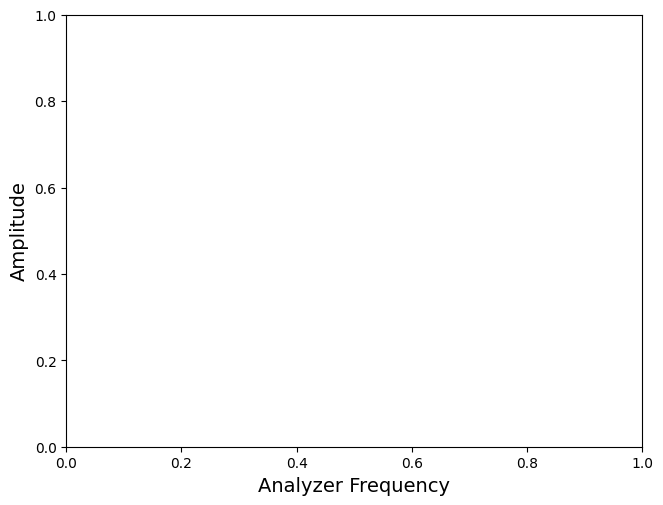

In [19]:
%matplotlib inline
#np.zeros((len(freqs),len(freqs),len(freqs)))

idx=5


fig= plt.figure()
ax=fig.add_axes([0.1, 0.1 ,0.9, 0.9])

ax.set_xlabel("Analyzer Frequency", fontsize=14)
ax.set_ylabel("Amplitude", fontsize=14)


ax.pcolormesh(Analyzer_freq,amplitudes,Data[:,:,idx],cmap= "viridis",shading="auto")
#ax.plot(freqs+LO_fluxline,freqs,'r',marker=".",linestyle = 'None')


## Program sweeping pump frequency and amplitude

The program here sweeps the amplitude of the pump. For each pump amplitude, the amplitude is then sweep. 


In [49]:
        
# # Frequency sweep 
# span=1 * u.MHz # Span of the pumping 
# df = 0.01 * u.MHz # Step of the pumping 
# freqs = np.arange(IF_fluxline-span/2, IF_fluxline+span/2, df) #sets of frequencies


# Frequency sweep 
span=10 * u.kHz # Span of the pumping 
df = 1 * u.kHz # Step of the pumping 
freqs = np.arange(IF_fluxline-span/2, IF_fluxline+span/2, df) #sets of frequencies

#Amplitude sweep
a_min = 0
a_max = 0.3
da = 0.1
amplitudes = np.arange(a_min, a_max + da / 2, da)  # +da/2 to add a_max to the scan (vector of amplitudes)


Data=np.zeros((len(freqs),pointsNum,len(amplitudes))) #data 


#defines the program 
with program() as MultiTriggerTest:
    
    a = declare(fixed)  # pump amplitude 
    f = declare(int) # frequency 
    n = declare(int) #iteration index
    n_st = declare_stream()
    
   
    with for_(a, a_min, a < a_max + da / 2, a + da):  # Notice it's < a_max + da/2 to include a_max
        
        with for_(*from_array(f,freqs)):  # Notice it's < a_max + da/2 to include a_max

            update_frequency("fluxline",f) # updates the IF frequency to the array 
            
            play("pumping"*amp(a), 'fluxline') #Plays the pump pulse on the flux line 

            pause() # pause to collect the data from the trigger 

           


job = qm.execute(MultiTriggerTest)  # Execute QUA program  

    


for k in range(len(amplitudes)):
    
    print(k/len(amplitudes))
    
    
    
    for j in range(len(freqs)):


        while not job.is_paused():
            time.sleep(0.001)

       

        #time.sleep(pointsNum/RBW_bandwidth**2) #time delay for the acquisition 
        time.sleep(0.1) 

        [Analyzer_freq, Analyzer_value] = sa.collect_spectrum() # Collect the spectrum 
        
        Data[j,:,k]=Analyzer_value.transpose()
       

        job.resume()  # Resume to the program
        
 #Data structure is a 3d matrix (set of 2d matrix stacked on top of each other)


2023-02-27 18:44:43,562 - qm - INFO - Flags: 
2023-02-27 18:44:43,563 - qm - INFO - Sending program to QOP
2023-02-27 18:44:43,596 - qm - INFO - Executing program
0.0
0.25
0.5
0.75


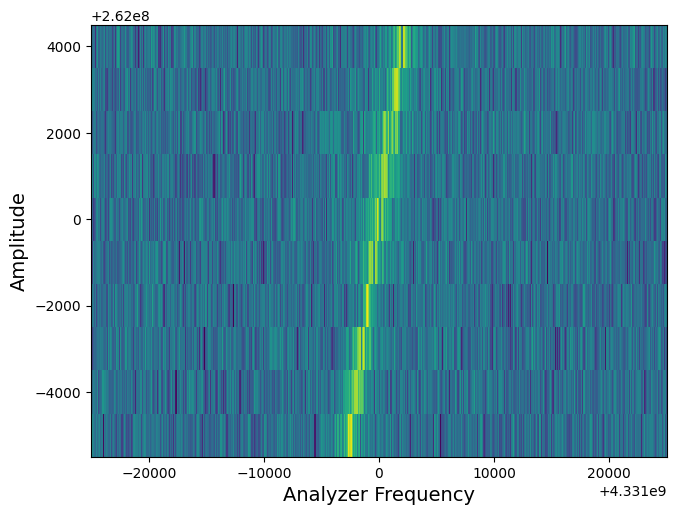

In [60]:
%matplotlib inline
#np.zeros((len(freqs),len(freqs),len(freqs)))

idx=3

fig= plt.figure()
ax=fig.add_axes([0.1, 0.1 ,0.9, 0.9])

ax.set_xlabel("Analyzer Frequency", fontsize=14)
ax.set_ylabel("Amplitude", fontsize=14)


ax.pcolormesh(Analyzer_freq,freqs,Data[:,:,idx],cmap= "viridis",shading="auto")
#ax.plot(freqs+LO_fluxline,freqs,'r',marker=".",linestyle = 'None')

## Full Measurement Code 

In [73]:
# Frequency sweep 
# span=1 * u.MHz # Span of the pumping 
# df = 0.01 * u.MHz # Step of the pumping 
# freqs = np.arange(IF_fluxline-span/2, IF_fluxline+span/2, df) #sets of frequencies


span=1 * u.MHz # Span of the pumping 
df = 0.01 * u.MHz # Step of the pumping 0.01
IF_center=0.2666e9 
freqs = np.arange(IF_center-span/2, IF_center+span/2, df) #sets of frequencies


waiting_acquisition_time=0.4
    

#Amplitude sweep
a_min = 0.15
a_max = 0.65
da = 0.01#0.005
amplitudes = np.arange(a_min, a_max + da / 2, da)  # +da/2 to add a_max to the scan (vector of amplitudes)

#Number of average
Number_Average=1

NumberPoints=freqs.shape[0]*amplitudes.shape[0]
TimePerPoint=(18*60)/880
print(NumberPoints)
print(NumberPoints*TimePerPoint/60)
print(NumberPoints*TimePerPoint*Number_Average/60)


5100
104.31818181818181
104.31818181818181


In [71]:
%%time

# Pumping frequency sweep (around the IF+LO that is set in the configuration file)
# span=1 * u.MHz # Span of the pumping 
# df = 0.05 * u.MHz # Step of the pumping 
# freqs = np.arange(IF_fluxline-span/2, IF_fluxline+span/2, df) #sets of frequencies





Data=np.zeros((len(freqs),pointsNum,len(amplitudes))) #data in the format of rows corresponding to all pumping frequencies 
                         
                            # Column to all the points at the analyzer and third dimensions for each amplitude
        
Analyzer_freq_all=np.zeros((len(freqs),pointsNum)) #sets of all frequencies used at the analyzer

#defines the program 
with program() as MultiTriggerTest:
    
    a = declare(fixed)  # pump amplitude 
    f = declare(int) # frequency 
    n = declare(int) #iteration index
    n_st = declare_stream()
    
   
    with for_(a, a_min, a < a_max + da / 2, a + da):  # Notice it's < a_max + da/2 to include a_max
        
        with for_(*from_array(f,freqs)):  # Notice it's < a_max + da/2 to include a_max

            update_frequency("fluxline",f) # updates the IF frequency to the array 
            
            play("pumping"*amp(a), 'fluxline') #Plays the pump pulse on the flux line 

            pause() # pause to collect the data from the trigger 

           


job = qm.execute(MultiTriggerTest)  # Execute QUA program  

    


for k in range(len(amplitudes)):
    
    print(k/len(amplitudes))

    
    for j in range(len(freqs)):


        while not job.is_paused():
            time.sleep(0.001)

        

        time.sleep(waiting_acquisition_time) #time delay for the acquisition 

        [Analyzer_freq, Analyzer_value] = sa.collect_spectrum() # Collect the spectrum 
        
        Analyzer_freq_all[j,:]=Analyzer_freq
        Data[j,:,k]=Analyzer_value.transpose()
       
        
        #Here the center frequency of the next measurement is set
        if j<(len(freqs)-1):
            sa.set_center_freq((freqs[j+1]+LO_fluxline)/2) #sets the new center frequency on the spectrum analyzer 
            time.sleep(0.2)
        else:
            sa.set_center_freq((freqs[0]+LO_fluxline)/2) #sets the new center frequency on the spectrum analyzer 
            time.sleep(0.2)
        job.resume()  # Resume to the program
    

    
 #Data structure is a 3d matrix (set of 2d matrix stacked on top of each other)


2023-03-23 19:46:48,750 - qm - INFO - Flags: 
2023-03-23 19:46:48,750 - qm - INFO - Sending program to QOP
2023-03-23 19:46:48,788 - qm - INFO - Executing program
0.0
0.047619047619047616
0.09523809523809523
0.14285714285714285
0.19047619047619047
0.23809523809523808
0.2857142857142857
0.3333333333333333
0.38095238095238093
0.42857142857142855
0.47619047619047616
0.5238095238095238
0.5714285714285714
0.6190476190476191
0.6666666666666666
0.7142857142857143
0.7619047619047619
0.8095238095238095
0.8571428571428571
0.9047619047619048
0.9523809523809523
Wall time: 43min 5s


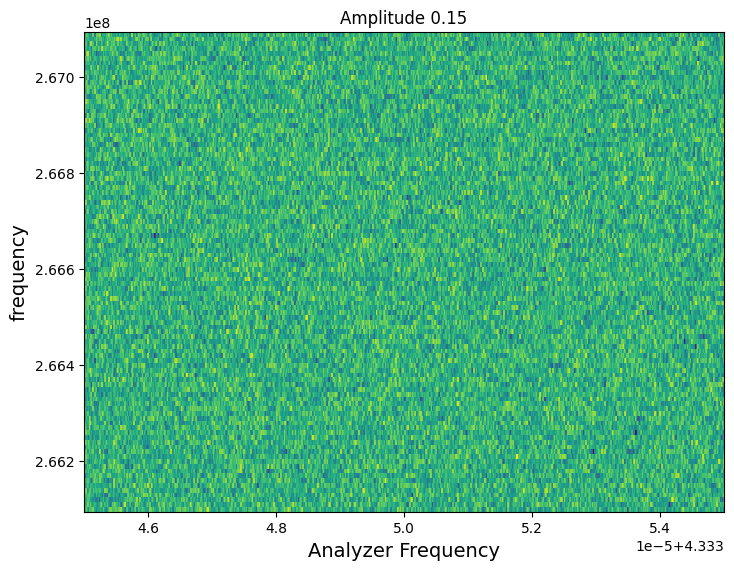

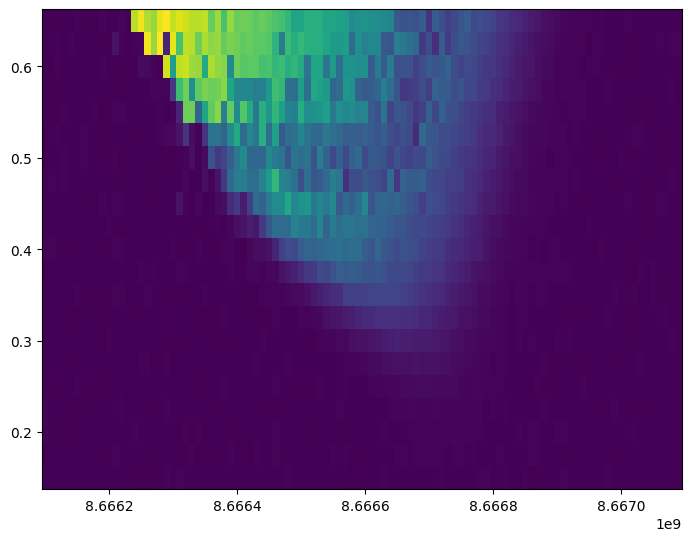

In [72]:
%matplotlib inline


idx=0


fig= plt.figure()
ax=fig.add_axes([0.1, 0.1 ,1, 1])

ax.set_xlabel("Analyzer Frequency", fontsize=14)
ax.set_ylabel("frequency", fontsize=14)
ax.set_title('Amplitude '+str(amplitudes[idx]))

ax.pcolormesh(Analyzer_freq_all[0,:]/1e9,freqs,Data[:,:,idx],cmap= "viridis",shading="auto")
#ax.plot(freqs+LO_fluxline,freqs,'r',marker=".",linestyle = 'None')


def dbm_to_watt(Data):
    return 10**(Data/10)

convert_dbm_to_watt=np.vectorize(dbm_to_watt)
watt_Data=convert_dbm_to_watt(Data)

integrate=np.zeros([amplitudes.shape[0], freqs.shape[0]])
                    
for idx in range(amplitudes.shape[0]):
    i=0
    
    for trace in watt_Data[:,:,idx]:
    
        integrate[idx,i]=np.trapz(trace, Analyzer_freq_all[i,:])
        i+=1
        
fig= plt.figure()
ax=fig.add_axes([0.1, 0.1 ,1, 1])                   
ax.pcolormesh( freqs+LO_fluxline,amplitudes,integrate,cmap= "viridis",shading="auto")

In [8]:
#Saving the data

cooldown_date="2023_02_24"
meastype="100ms_1ms_0p4" #Final file name 
name="Run01"
device="123"

datadict={}
datadict["Analyzer_center_freq"]=centerFreq
datadict["Analyzer_span"]=spanFreq
datadict["Numpoints"]=pointsNum
datadict["RBW_bandwidth"]=RBW_bandwidth
datadict["VBW_bandwidth"]=VBW_bandwidth
datadict["amplitudes"]=amplitudes  
datadict["Analyzer_freq"]=Analyzer_freq_all
datadict["Pump_freq"]=freqs+LO_fluxline
datadict["Data"]=Data


NameError: name 'amplitudes' is not defined

In [37]:
an.save_data(datadict, meastype, name, device, cooldown_date, bias=0, filepath=r"C:\Users\hqclabo\Documents\Data\gbeaulieu\Two_Photon\\")


Data saved


## Full measumerent code with average

This allows performing the measurement code N times and each time saving a new matrix data to be averaged later

In [ ]:
%%time

# Pumping frequency sweep (around the IF+LO that is set in the configuration file)
# span=1 * u.MHz # Span of the pumping 
# df = 0.05 * u.MHz # Step of the pumping 
# freqs = np.arange(IF_fluxline-span/2, IF_fluxline+span/2, df) #sets of frequencies

#Saving parameters 
cooldown_date="2023_03_10"
name="Map4"
device="123"

datadict={}
datadict["Analyzer_center_freq"]=centerFreq
datadict["Analyzer_span"]=spanFreq
datadict["Numpoints"]=pointsNum
datadict["RBW_bandwidth"]=RBW_bandwidth
datadict["VBW_bandwidth"]=VBW_bandwidth
datadict["amplitudes"]=amplitudes  
datadict["Pump_freq"]=freqs+LO_fluxline

Data=np.zeros((len(freqs),pointsNum,len(amplitudes))) #data in the format of rows corresponding to all pumping frequencies 
                         
                            # Column to all the points at the analyzer and third dimensions for each amplitude
        
Analyzer_freq_all=np.zeros((len(freqs),pointsNum)) #sets of all frequencies used at the analyzer

#defines the program 
with program() as MultiTriggerTest:
    
    a = declare(fixed)  # pump amplitude 
    f = declare(int) # frequency 
    n = declare(int) #iteration index
    n_st = declare_stream()
    
   
    with for_(a, a_min, a < a_max + da / 2, a + da):  # Notice it's < a_max + da/2 to include a_max
        
        with for_(*from_array(f,freqs)):  # Notice it's < a_max + da/2 to include a_max

            update_frequency("fluxline",f) # updates the IF frequency to the array 
            
            play("pumping"*amp(a), 'fluxline') #Plays the pump pulse on the flux line 

            pause() # pause to collect the data from the trigger 

           

for i in range(0,Number_Average,1) : 
    
    job = qm.execute(MultiTriggerTest)  # Execute QUA program  


    for k in range(len(amplitudes)):

        print(k/len(amplitudes))


        for j in range(len(freqs)):


            while not job.is_paused():
                time.sleep(0.001)



            time.sleep(waiting_acquisition_time) #time delay for the acquisition 

            [Analyzer_freq, Analyzer_value] = sa.collect_spectrum() # Collect the spectrum 

            Analyzer_freq_all[j,:]=Analyzer_freq
            Data[j,:,k]=Analyzer_value.transpose()


            #Here the center frequency of the next measurement is set
            if j<(len(freqs)-1):
                sa.set_center_freq((freqs[j+1]+LO_fluxline)/2) #sets the new center frequency on the spectrum analyzer 
                time.sleep(0.2)
            else:
                sa.set_center_freq((freqs[0]+LO_fluxline)/2) #sets the new center frequency on the spectrum analyzer 
                time.sleep(0.2)
            job.resume()  # Resume to the program

            
            
   
    meastype="Map_0p25_1"+str(i) #Final file name 
    datadict["Data"]=Data
    datadict["Analyzer_freq"]=Analyzer_freq_all
    an.save_data(datadict, meastype, name, device, cooldown_date, bias=0, filepath=r"C:\Users\hqclabo\Documents\Data\gbeaulieu\Two_Photon\\")

    
 #Data structure is a 3d matrix (set of 2d matrix stacked on top of each other)

2023-03-14 22:40:18,314 - qm - INFO - Flags: 
2023-03-14 22:40:18,315 - qm - INFO - Sending program to QOP
2023-03-14 22:40:18,553 - qm - INFO - Executing program
0.0
0.012345679012345678
0.024691358024691357
0.037037037037037035
0.04938271604938271
0.06172839506172839
0.07407407407407407
0.08641975308641975
0.09876543209876543
0.1111111111111111
0.12345679012345678
0.13580246913580246
0.14814814814814814
0.16049382716049382
0.1728395061728395
0.18518518518518517
0.19753086419753085
0.20987654320987653
0.2222222222222222
0.2345679012345679
0.24691358024691357
0.25925925925925924
0.2716049382716049
0.2839506172839506
0.2962962962962963
0.30864197530864196
0.32098765432098764
0.3333333333333333
0.345679012345679
0.35802469135802467
0.37037037037037035
0.38271604938271603
0.3950617283950617
0.4074074074074074
0.41975308641975306
0.43209876543209874
0.4444444444444444
0.4567901234567901
0.4691358024691358
0.48148148148148145
0.49382716049382713
0.5061728395061729
0.5185185185185185
0.53086

## Measurement of a single amplitude cut 

This allows the measurement of a single amplitude cut, n times to get an average

In [24]:
# Frequency sweep 
# span=1 * u.MHz # Span of the pumping 
# df = 0.01 * u.MHz # Step of the pumping 
# freqs = np.arange(IF_fluxline-span/2, IF_fluxline+span/2, df) #sets of frequencies

save=True  


span=0.9 * u.MHz # Span of the pumping 
df = 0.01 * u.MHz # Step of the pumping 0.01  #0.01
IF_center=0.2666e9 
freqs = np.arange(IF_center-span/2, IF_center+span/2, df) #sets of frequencies



waiting_acquisition_time=0.4
    

#Amplitude for the sweep
amplitudes = [0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7]
amp_value=amplitudes[0] # dummy value to be define for the program 

#Number of average
n_avg = 35

#Expected time 
NumberPoints=freqs.shape[0]*len(amplitudes)
TimePerPoint=(18*60)/880
print(NumberPoints)
print(NumberPoints*TimePerPoint/60)
print(NumberPoints*TimePerPoint*n_avg/60)

810
16.56818181818182
579.8863636363636


In [25]:
%%time


#Saving parameters 
cooldown_date="2023_03_17"
name="Cut_average_full"
device="123"

datadict={}
datadict["Analyzer_center_freq"]=centerFreq
datadict["Analyzer_span"]=spanFreq
datadict["Numpoints"]=pointsNum
datadict["RBW_bandwidth"]=RBW_bandwidth
datadict["VBW_bandwidth"]=VBW_bandwidth
datadict["amplitudes"]=amplitudes  
datadict["Pump_freq"]=freqs+LO_fluxline
datadict["n_avg"]=n_avg




# Calculate the integral for each graph 
def dbm_to_watt(Data):
    return 10**(Data/10)
convert_dbm_to_watt=np.vectorize(dbm_to_watt)



Data=np.zeros((len(freqs),pointsNum,n_avg)) #data in the format of rows corresponding to each measurement and column from the spectrum analyzer and we get one for each iteration to average 
average_trace=np.zeros((len(amplitudes),len(freqs)))  # data in the format of each row is a precice amplitude and each column is a point from the integration                          
Analyzer_freq_all=np.zeros((len(freqs),pointsNum)) #sets of all frequencies used at the analyzer

#defines the program 
with program() as MultiTriggerTest:
    
    a = declare(fixed)  # pump amplitude 
    f = declare(int) # frequency 
    n = declare(int) #iteration index
    n_st = declare_stream()
    
    with for_each_(a, amplitudes): # for all the amplitudes 

        with for_(n, 0, n < n_avg, n + 1):  # Notice it's < a_max + da/2 to include a_max

            with for_(*from_array(f,freqs)):  # Notice it's < a_max + da/2 to include a_max

                update_frequency("fluxline",f) # updates the IF frequency to the array 

                play("pumping"*amp(a), 'fluxline') #Plays the pump pulse on the flux line 

                pause() # pause to collect the data from the trigger 




 
    job = qm.execute(MultiTriggerTest)  # Execute QUA program  

for l in range(len(amplitudes)):
    
    for k in range(n_avg):

        print(k/n_avg)

        for j in range(len(freqs)):

            while not job.is_paused():
                time.sleep(0.001)


            time.sleep(waiting_acquisition_time) #time delay for the acquisition 

            [Analyzer_freq, Analyzer_value] = sa.collect_spectrum() # Collect the spectrum 

            Analyzer_freq_all[j,:]=Analyzer_freq
            Data[j,:,k]=Analyzer_value.transpose() 


            #Here the center frequency of the next measurement is set
            if j<(len(freqs)-1):
                sa.set_center_freq((freqs[j+1]+LO_fluxline)/2) #sets the new center frequency on the spectrum analyzer 
                time.sleep(0.2)
            else:
                sa.set_center_freq((freqs[0]+LO_fluxline)/2) #sets the new center frequency on the spectrum analyzer 
                time.sleep(0.2)
            job.resume()  # Resume to the program

    
    #Integrate the Data and convert to a single trace 
    watt_Data=convert_dbm_to_watt(Data)
    integrate=np.zeros((n_avg,freqs.shape[0]))

    for idx in range(n_avg):
        i=0

        for trace in watt_Data[:,:,idx]:

            integrate[idx,i]=np.trapz(trace, Analyzer_freq_all[i,:]) 
            i+=1

    average_trace[l,:]=np.mean(integrate, axis=0)
    
    if save: 
        meastype="Map_amp"+str(amplitudes[l]) #Final file name 
        datadict["Data"]=Data
        datadict["Analyzer_freq"]=Analyzer_freq_all
        an.save_data(datadict, meastype, name, device, cooldown_date, bias=0, filepath=r"C:\Users\hqclabo\Documents\Data\gbeaulieu\Two_Photon\\")
    
 #Data structure is a 3d matrix (set of 2d matrix stacked on top of each other)

2023-03-24 00:06:57,033 - qm - INFO - Flags: 
2023-03-24 00:06:57,034 - qm - INFO - Sending program to QOP
2023-03-24 00:06:57,079 - qm - INFO - Executing program
0.0
0.02857142857142857
0.05714285714285714
0.08571428571428572
0.11428571428571428
0.14285714285714285
0.17142857142857143
0.2
0.22857142857142856
0.2571428571428571
0.2857142857142857
0.3142857142857143
0.34285714285714286
0.37142857142857144
0.4
0.42857142857142855
0.45714285714285713
0.4857142857142857
0.5142857142857142
0.5428571428571428
0.5714285714285714
0.6
0.6285714285714286
0.6571428571428571
0.6857142857142857
0.7142857142857143
0.7428571428571429
0.7714285714285715
0.8
0.8285714285714286
0.8571428571428571
0.8857142857142857
0.9142857142857143
0.9428571428571428
0.9714285714285714
Data saved
0.0
0.02857142857142857
0.05714285714285714
0.08571428571428572
0.11428571428571428
0.14285714285714285
0.17142857142857143
0.2
0.22857142857142856
0.2571428571428571
0.2857142857142857
0.3142857142857143
0.34285714285714286


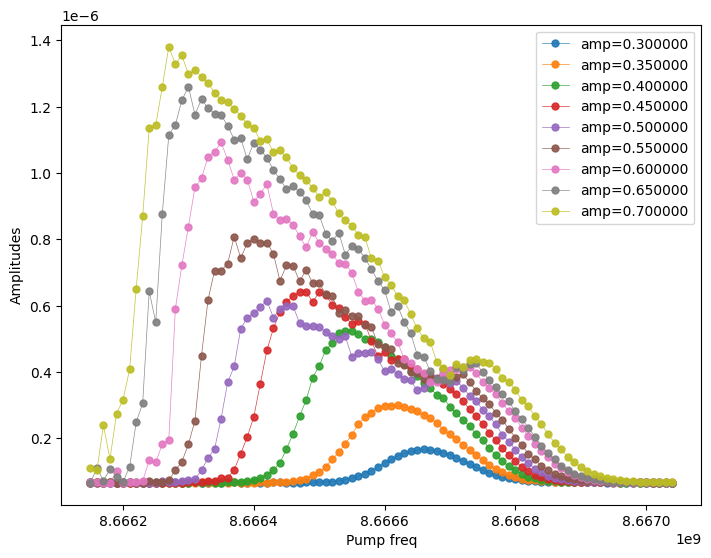

In [26]:
#Plot the difference traces averaged trace 

fig= plt.figure()
ax=fig.add_axes([0.1, 0.1 ,1, 1])

for i in range(len(amplitudes)):
     plt.plot(freqs+LO_fluxline,average_trace[i,:],'.-',label=f'amp={amplitudes[i]:1f}', alpha=.9, lw=.5, ms=10)

ax.set_xlabel("Pump freq")
ax.set_ylabel("Amplitudes")
ax.legend()


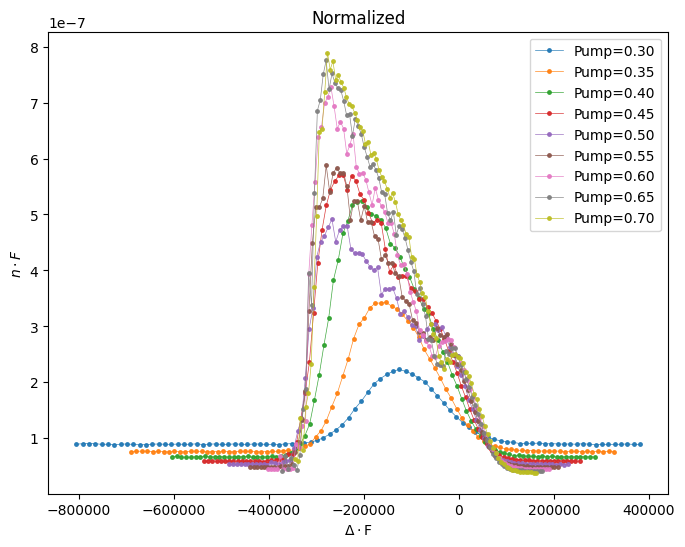

In [47]:
fig, ax = plt.subplots( ncols=1, figsize=(8,6))

center_freq=8666754000.0
Gi=0.4
for i in range(len(amplitudes)):
    Gx=amplitudes[i]
    ax.plot((freqs+LO_fluxline-center_freq)*Gi/Gx,average_trace[i,:]*Gi/Gx, '.-',  label=f'Pump={amplitudes[i]:.2f}', alpha=.9, lw=.5, ms=5)

ax.set_title("Normalized")
ax.set_xlabel('$\Delta\cdot$F')
ax.set_ylabel('$n\cdot F$')
ax.legend()
#ax.set_xlim(-0.5e6, 0.3e6)

In [39]:
(freqs-center_freq)

array([-8.400604e+09, -8.400594e+09, -8.400584e+09, -8.400574e+09,
       -8.400564e+09, -8.400554e+09, -8.400544e+09, -8.400534e+09,
       -8.400524e+09, -8.400514e+09, -8.400504e+09, -8.400494e+09,
       -8.400484e+09, -8.400474e+09, -8.400464e+09, -8.400454e+09,
       -8.400444e+09, -8.400434e+09, -8.400424e+09, -8.400414e+09,
       -8.400404e+09, -8.400394e+09, -8.400384e+09, -8.400374e+09,
       -8.400364e+09, -8.400354e+09, -8.400344e+09, -8.400334e+09,
       -8.400324e+09, -8.400314e+09, -8.400304e+09, -8.400294e+09,
       -8.400284e+09, -8.400274e+09, -8.400264e+09, -8.400254e+09,
       -8.400244e+09, -8.400234e+09, -8.400224e+09, -8.400214e+09,
       -8.400204e+09, -8.400194e+09, -8.400184e+09, -8.400174e+09,
       -8.400164e+09, -8.400154e+09, -8.400144e+09, -8.400134e+09,
       -8.400124e+09, -8.400114e+09, -8.400104e+09, -8.400094e+09,
       -8.400084e+09, -8.400074e+09, -8.400064e+09, -8.400054e+09,
       -8.400044e+09, -8.400034e+09, -8.400024e+09, -8.400014e

In [27]:
# Savedata if not done before 


cooldown_date="2023_03_17"
meastype="full_average" #Final file name 
name="Run01"
device="123"

datadict={}
datadict["Analyzer_center_freq"]=centerFreq
datadict["Analyzer_span"]=spanFreq
datadict["Numpoints"]=pointsNum
datadict["RBW_bandwidth"]=RBW_bandwidth
datadict["VBW_bandwidth"]=VBW_bandwidth
datadict["amplitudes"]=amplitudes  
datadict["Analyzer_freq"]=Analyzer_freq_all
datadict["Pump_freq"]=freqs+LO_fluxline
datadict["Data"]=Data
datadict["average_trace"]=average_trace

In [28]:
an.save_data(datadict, meastype, name, device, cooldown_date, bias=0, filepath=r"C:\Users\hqclabo\Documents\Data\gbeaulieu\Two_Photon\\")

Data saved


(90, 1001, 1)


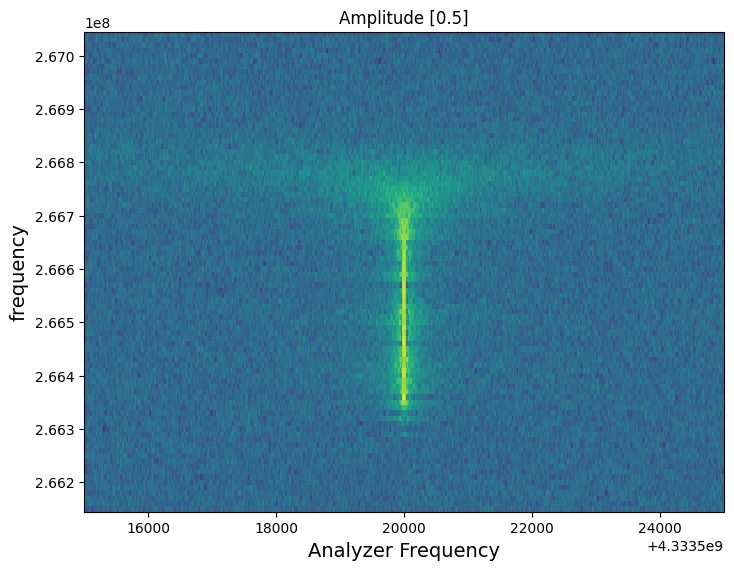

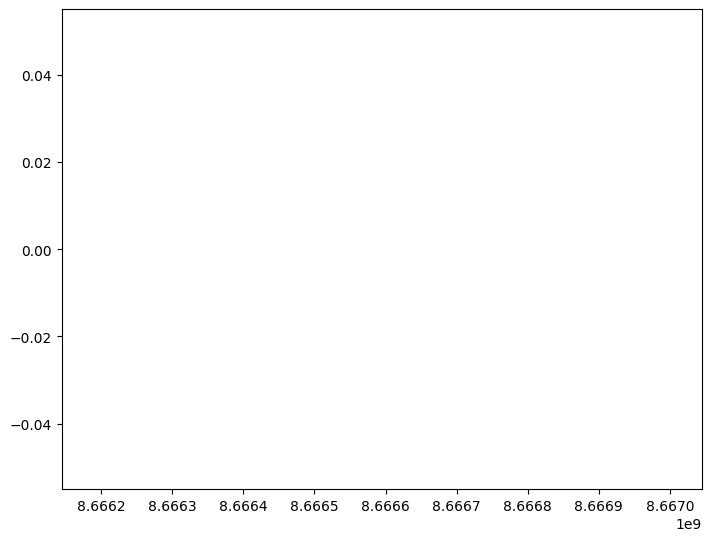

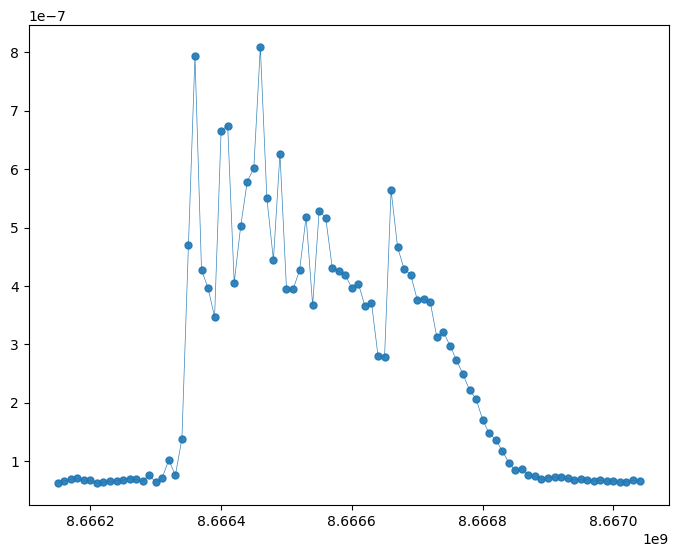

In [7]:
# full graph of the last data for testing 

idx=0 # Average we are looking at 

fig= plt.figure()
ax=fig.add_axes([0.1, 0.1 ,1, 1])

ax.set_xlabel("Analyzer Frequency", fontsize=14)
ax.set_ylabel("frequency", fontsize=14)
ax.set_title('Amplitude '+str(amplitudes))

ax.pcolormesh(Analyzer_freq,freqs,Data[:,:,idx],cmap= "viridis",shading="auto")
print(Data.shape)


n_avgarray = np.arange(0,n_avg, 1)

# Calculate the integral for each graph 
def dbm_to_watt(Data):
    return 10**(Data/10)

convert_dbm_to_watt=np.vectorize(dbm_to_watt)
watt_Data=convert_dbm_to_watt(Data)

integrate=np.zeros((n_avg,freqs.shape[0]))

for idx in range(n_avg):
    i=0
    
    for trace in watt_Data[:,:,idx]:
    
        integrate[idx,i]=np.trapz(trace, Analyzer_freq_all[i,:]) 
        i+=1
        
        
    
fig= plt.figure()
ax=fig.add_axes([0.1, 0.1 ,1, 1])                   
ax.pcolormesh( freqs+LO_fluxline,n_avgarray ,integrate,cmap= "viridis",shading="auto")

average_trace=np.mean(integrate, axis=0)

fig= plt.figure()
ax=fig.add_axes([0.1, 0.1 ,1, 1])   
plt.plot(freqs+LO_fluxline,average_trace,'.-', alpha=.9, lw=.5, ms=10)


In [137]:
freqs+LO_fluxline
average_trace.shape
(freqs+LO_fluxline).shape
amplitude=[0, 1, 0.5]

for idx,value in enumerate(amplitude):
    print(value)

0
1
0.5


## Full measumrent with sweeping the amplitude 

In [210]:


# Pumping frequency sweep (around the IF+LO that is set in the configuration file)
span=1 * u.MHz # Span of the pumping 
df = 0.1 * u.MHz # Step of the pumping 
freqs = np.arange(IF_fluxline-span/2, IF_fluxline+span/2, df) #sets of frequencies


#Analyzer parameter

sa =  FSW('TCPIP0::169.254.209.74::inst0::INSTR')

### Tunable parameters
centerSpan = True
spanFreq = 0.1e6    
pointsNum = 1001
RBW_bandwidth = 100
VBW_bandwidth = 100
level=0.5 #trigger level 
    
sa.set_RBW(RBW_bandwidth) # set RBW bandwidth
sa.set_VBW(VBW_bandwidth) # set the VBW bandwidth 
sa.set_center_freq(freqs[0]+LO_fluxline) #First sets the first center frequency based on first frequnecy of sweep
sa.set_span(spanFreq) #set the frequency span 

sa.set_center_freq_up_mode(0.1e6)

sa.set_trig(level) # sets the continuous trigger mode 
sa.set_input_coupling("AC")
sa.set_input_impedance(50)
sa.set_continuous("on")
sa.set_display(0)


#Amplitude sweep
a_min = 0
a_max = 0.3
da = 0.1
amplitudes = np.arange(a_min, a_max + da / 2, da)  # +da/2 to add a_max to the scan (vector of amplitudes)


Data=np.zeros((len(amplitudes),pointsNum,len(freqs))) #data in the format of rows corresponding to all pumping frequencies 
                         
                            # Column to all the points at the analyzer and third dimensions for each amplitude
        
Analyzer_freq_all=np.zeros((len(freqs),pointsNum)) #sets of all frequencies used at the analyzer

#defines the program 
with program() as MultiTriggerTest:
    
    a = declare(fixed)  # pump amplitude 
    f = declare(int) # frequency 
    n = declare(int) #iteration index
    n_st = declare_stream()
    
   
    with for_(*from_array(f,freqs)):  # Notice it's < a_max + da/2 to include a_max
        
        update_frequency("fluxline",f) # updates the IF frequency to the array 
        
        with for_(a, a_min, a < a_max + da / 2, a + da):  # Notice it's < a_max + da/2 to include a_max
            
            play("pumping"*amp(a), 'fluxline') #Plays the pump pulse on the flux line 

            pause() # pause to collect the data from the trigger 

           


job = qm.execute(MultiTriggerTest)  # Execute QUA program  

    


for k in range(len(freqs)):
    
    print(k/len(freqs))
    
    if k>0:
        Analyzer_freq_all[k,:]=Analyzer_value.transpose()
   
      
    for j in range(len(amplitudes)):


        while not job.is_paused():
            time.sleep(0.001)

        

        time.sleep(pointsNum/RBW_bandwidth**2) #time delay for the acquisition 

        [Analyzer_freq, Analyzer_value] = sa.collect_spectrum() # Collect the spectrum 
        
        Data[j,:,k]=Analyzer_value.transpose()
       
        #Here the center frequency of the next measurement is set
 
        job.resume()  # Resume to the program
   

    if k>0:
        time.sleep(0.5)
        sa.set_center_freq(freqs[k]+LO_fluxline) #sets the new center frequency on the spectrum analyzer 
        time.sleep(0.5)
    else:
        time.sleep(0.5)
        sa.set_center_freq(freqs[0]+LO_fluxline) #sets the new center frequency on the spectrum analyzer 
        time.sleep(0.5)


2023-02-23 19:44:11,142 - qm - INFO - Flags: 
2023-02-23 19:44:11,142 - qm - INFO - Sending program to QOP
2023-02-23 19:44:11,173 - qm - INFO - Executing program
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


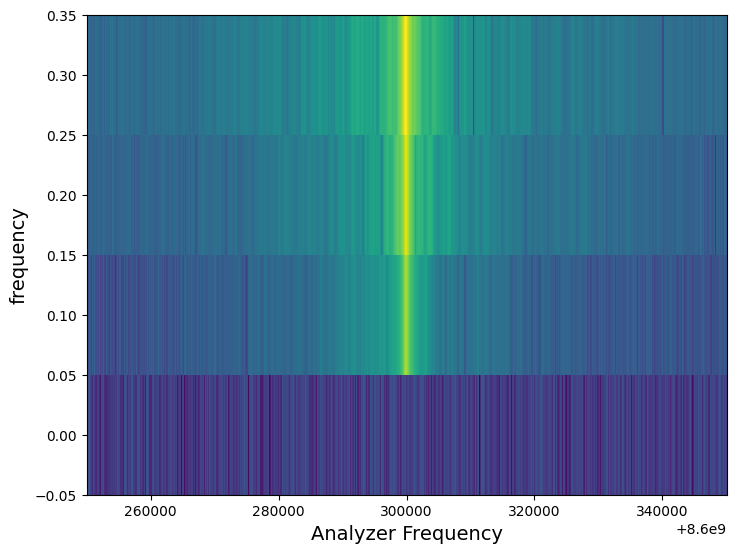

In [215]:
%matplotlib inline
#np.zeros((len(freqs),len(freqs),len(freqs)))

idx=0

fig= plt.figure()
ax=fig.add_axes([0.1, 0.1 ,1, 1])

ax.set_xlabel("Analyzer Frequency", fontsize=14)
ax.set_ylabel("frequency", fontsize=14)


ax.pcolormesh(Analyzer_freq,amplitudes,Data[:,:,idx],cmap= "viridis",shading="auto")
#ax.plot(freqs+LO_fluxline,freqs,'r',marker=".",linestyle = 'None')

In [209]:
#Measurement process : check if the delay for acquisition is actually sufficently long given your setup 
# Setup the autocalibration and the config file 
#Then, set the parameters and measure -> should probably calculate the number of points that make sense given your RBW 

array([[-1.18308884e+02, -1.19411766e+02, -1.18252663e+02, ...,
         9.90999953e+37,  9.90999953e+37,  9.90999953e+37],
       [-1.21270088e+02, -1.20495392e+02, -1.18441376e+02, ...,
        -1.18088547e+02, -1.14885170e+02, -1.17073578e+02],
       [-1.21322716e+02, -1.16610374e+02, -1.18893578e+02, ...,
        -1.16122261e+02, -1.19471100e+02, -1.19081093e+02],
       [-1.16607559e+02, -1.17442352e+02, -1.17747765e+02, ...,
        -1.17871376e+02, -1.15722717e+02, -1.18256935e+02]])

## Comment : you cannot select a bandwidth too small for some reason 

Two things to consider : when you lower the bandwidth of the analyzer, the pulse duration might finish before you have collected all the data at the Analyzer. Therefore, you might want to increase the pulse duration  

In [261]:
len(amplitudes)

31

In [ ]:
#OLD measurement code 

# Pumping frequency sweep (around the IF+LO that is set in the configuration file)
# span=1 * u.MHz # Span of the pumping 
# df = 0.05 * u.MHz # Step of the pumping 
# freqs = np.arange(IF_fluxline-span/2, IF_fluxline+span/2, df) #sets of frequencies


# Frequency sweep 
span=10 * u.kHz # Span of the pumping 
df = 2 * u.kHz # Step of the pumping 
freqs = np.arange(IF_fluxline-span/2, IF_fluxline+span/2, df) #sets of frequencies



#Analyzer parameter

sa =  FSW('TCPIP0::169.254.209.74::inst0::INSTR')

### Tunable parameters
# centerSpan = True
# spanFreq = 0.1e6    
# pointsNum = 1001
# RBW_bandwidth = 50
# VBW_bandwidth = 50
# level=0.5 #trigger level 
# waiting_acquisition_time=pointsNum/RBW_bandwidth**2
    
# sa.set_RBW(RBW_bandwidth) # set RBW bandwidth
# sa.set_VBW(VBW_bandwidth) # set the VBW bandwidth 
# sa.set_center_freq(freqs[0]+LO_fluxline) #First sets the first center frequency based on first frequnecy of sweep
# sa.set_span(spanFreq) #set the frequency span 

# sa.set_center_freq_up_mode(0.1e6)

# sa.set_trig(level) # sets the continuous trigger mode 
# sa.set_input_coupling("AC")
# sa.set_input_impedance(50)
# sa.set_continuous("on")
# sa.set_display(0)


#Amplitude sweep
a_min = 0
a_max = 0.3
da = 0.05
amplitudes = np.arange(a_min, a_max + da / 2, da)  # +da/2 to add a_max to the scan (vector of amplitudes)


Data=np.zeros((len(freqs),pointsNum,len(amplitudes))) #data in the format of rows corresponding to all pumping frequencies 
                         
                            # Column to all the points at the analyzer and third dimensions for each amplitude
        
Analyzer_freq_all=np.zeros((len(freqs),pointsNum)) #sets of all frequencies used at the analyzer

#defines the program 
with program() as MultiTriggerTest:
    
    a = declare(fixed)  # pump amplitude 
    f = declare(int) # frequency 
    n = declare(int) #iteration index
    n_st = declare_stream()
    
   
    with for_(a, a_min, a < a_max + da / 2, a + da):  # Notice it's < a_max + da/2 to include a_max
        
        with for_(*from_array(f,freqs)):  # Notice it's < a_max + da/2 to include a_max

            update_frequency("fluxline",f) # updates the IF frequency to the array 
            
            play("pumping"*amp(a), 'fluxline') #Plays the pump pulse on the flux line 

            pause() # pause to collect the data from the trigger 

           


job = qm.execute(MultiTriggerTest)  # Execute QUA program  

    


for k in range(len(amplitudes)):
    
    print(k/len(amplitudes))

    
    for j in range(len(freqs)):


        while not job.is_paused():
            time.sleep(0.001)

        

        time.sleep(waiting_acquisition_time) #time delay for the acquisition 

        [Analyzer_freq, Analyzer_value] = sa.collect_spectrum() # Collect the spectrum 
        
        Analyzer_freq_all[j,:]=Analyzer_freq
        Data[j,:,k]=Analyzer_value.transpose()
       
        
        #Here the center frequency of the next measurement is set
        if j<(len(freqs)-1):
            sa.set_center_freq(freqs[j+1]+LO_fluxline) #sets the new center frequency on the spectrum analyzer 
            time.sleep(0.05)
        else:
            sa.set_center_freq(freqs[0]+LO_fluxline) #sets the new center frequency on the spectrum analyzer 
            time.sleep(0.05)
        job.resume()  # Resume to the program
    

    
 #Data structure is a 3d matrix (set of 2d matrix stacked on top of each other)
